<a href="https://colab.research.google.com/github/hongsy0113/cose461-NLP-project-choi-hong/blob/main/LSTM%EC%9D%98_%EC%82%AC%EB%B3%B8(gender).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soynlp
!pip install konlpy
!pip install tensorflow

from soynlp.normalizer import *
import soynlp

import json
from pandas import json_normalize

import torch
from torch import nn

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 416 kB 5.4 MB/s 
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 448 kB 35.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# json data 파일들을 google drive에 저장
# google drive 에 있는 파일들을 접근하기 위해 mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. lstm 모델

https://wikidocs.net/44249 
이 내용 거의 따라함

 lstm 모델 따라하기 2 의 아이디어
- 같은 화자의 데이터는 하나의 덩어리로 처리하도록

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/cose461/data_20.csv")

## 데이터 전처리


In [ ]:
from soynlp.normalizer import *
from konlpy.tag import Okt
import re

okt = Okt()

def clean(doc) :

  doc = doc.replace('#@이모티콘#', '이모티콘')

  pattern = '(#@[^#]+#)'
  doc = re.sub(pattern, '', doc)

  new_doc = list()
  doc = okt.pos(doc, norm=True)

  stop_tags = ['Determiner', 'Josa'] #, 'Foreign'] # 'foreign' 은 살려보자. ((이모티콘))으로 통일
  stop_words = ['은', '는', '이', '가', '']
  for text, tag in doc:  

    if tag in stop_tags:
      continue
    
    if tag == 'Foreign':
      text = '((이모티콘))'

    text = re.sub(r'[^ㄱ-ㅣ가-힣?.!~:())\^]+', '', text)  # remove digits. ^, :, ) 는 들어가게
    text = emoticon_normalize(text, num_repeats=2) # remove repeated emoticon. e.g) ㅋㅋㅋㅋ=>ㅋㅋ, ㅠㅠㅠㅠ=>ㅠㅠ
    text = repeat_normalize(text, num_repeats=1) # remove repeated character
    
    if text in stop_words or (tag=='Verb' and len(text)<=1):
      continue
      
    new_doc.append(text)

  return new_doc

In [ ]:
clean('#@시스템#사진 이름, #@이름# ♥️♥️♥️')
#emoticon_normalize("ㅋㅋㅋㅋ아아아아ㅋㅋㅋ쿠ㅜㅜㅜㅜㅋㅋㅋㅋㅋ")
#repeat_normalize("아아아아아 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ")

['사진', '이름', '((이모티콘))']

In [ ]:
df['sents'] = df['utterance'].apply(clean)
df.head(10)

,index,utterance,P_gender,sents
0,"('d681fd70-af0d-5821-bd54-f411a26a2551', 'P01')",나 할미 생일이라서 파뤼파뤼~ 저녁 먹고 올게 먹구옴 나원래 혼자 먹고 방에 들어옴...,0,"[나, 할미, 생일, 파뤼파뤼, ~, 저녁, 먹고, 올게, 먹구, 옴, 나, 원, ..."
1,"('a9458b1e-2eb0-51b3-869e-665816baa439', 'P02')",근데 서울은 요즘 초큼 그런거같기두하공 ㅠ 부평? 삼산동? 오 상동어디??,0,"[근데, 서울, 요즘, 초, 그런거, 같기두, 하, 공, ㅠ, 부평, ?, 삼산동,..."
2,"('349322b2-f378-536e-a458-334b467bbb53', 'P02')",그니까 ㅋㅋㅋㅋㅋㅋ 맘먹었어지금ㅋㅋㅋㅋㅋㅋ 담에 집들이때나 해서 같이 한번 모여보장 오올,0,"[그니까, ㅋㅋㅋ, 맘, 먹었어, 지금, ㅋㅋㅋ, 담, 집들이, 때, 해서, 같이,..."
3,"('6721f5f0-5b9e-5e76-b5a8-dca6271695b0', 'P04')",내는 지하철,0,"[내는, 지하철]"
4,"('b1300897-af6a-5a39-aa15-e7901c7137c9', 'P03')",강화도?,0,"[강화도, ?]"
5,"('d869613c-5add-5b2b-8df4-7c33233ed6ee', 'P01')",여행하면서 많이 만나네 어떤 사람은 라오스에서 남친 만났대 라오스 남부를 갔대.. ...,0,"[여행, 하면서, 많이, 만나네, 어떤, 사람, 라오스, 남친, 만났대, 라오스, ..."
6,"('7ad5adee-b626-5d94-8a47-11e18b9fdb4d', 'P02')",둘다 똑같은데 공항은 혹시 늦거나 기다려야되거나 시간 촉박할까바 그러는거가툼 둘다똑...,0,"[둘다, 똑같은데, 공항, 혹시, 늦거나, 기다려야되, 거나, 시간, 촉박할까, 바..."
7,"('00b2ad12-cf69-5755-bdca-0f453b4f175d', 'P01')",어이없어 아니야~그냥 돌아가는것도 싫고 해서 탔어 도착지도 그냥 그 105번 내리는...,0,"[어이없어, 아니야, ~, 그냥, 돌아가는것도, 싫고, 해서, 탔어, 도착, 지도,..."
8,"('74034247-a526-50d4-8494-c01e557c72cc', 'P02')",저녁에 갈거야 너는? 집에 간다고 너는? 7시 응 어디 아프니? 잘했쓰~~~ 그래라,0,"[저녁, 갈거야, 너, ?, 집, 간다, 너, ?, 시, 응, 어디, 아프니, ?,..."
9,"('32da1e90-947b-5729-89ae-62d8294077e0', 'P02')",님잠만여 저 밖이엿어요 깨잇어?? 요즘 같습니다 ㅋㅋㅋㅋㅇ 일할때보다 뭔가 더 나돌...,0,"[님잠만, 저, 밖, 엿, 어요, 깨, 잇어, ??, 요즘, 같습니다, ㅋㅋㅋㅇ, ..."


In [ ]:
# 전처리한 데이터프레임 저장
output_file = '/content/gdrive/MyDrive/cose461/result_data_20.csv'
df.to_csv(output_file, index=False, encoding="utf-8-sig")

데이터 전처리 고려해야 할 점 ㅜㅜ

- ㅋㅋㅋㅋ, ㅇㅇㅇㅇ 어떻게 처리할지. 단순히 여러개 있어도 다 같은 걸로 취급할지 말지
- !, ? 도 마찬가지. soynlp의 textonly 함수를 통해 기호들은 제거가 쉽게 가능할듯 한데. 그럼 정보의 손실이 있을수도
- 이모티콘 이름. 우리 데이터에서 사람 이름은 #@이름# 으로 되어있음. 
- 형태소 분석

### train, test data 만들기 및 정수 인코딩

In [ ]:
# 전처리한 데이터 read_csv로 가져오기
df = pd.read_csv("/content/gdrive/MyDrive/cose461/my_result_data_20.csv")

In [ ]:
X = df['sents']
y = df['P_gender']

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(len(tokenizer.word_index))

226216


In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)     # data 적게 할 때는 division by zero 나올수도
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 226216
등장 빈도가 1번 이하인 희귀 단어의 수: 134915
단어 집합에서 희귀 단어의 비율: 59.639901686883334
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1620115188483213


In [ ]:
# 전체 단어 개수 중 빈도수 threshold 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 91302


In [ ]:
#tokenizer = Tokenizer(vocab_size,  filters='[\\].,\t\n')#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') 
tokenizer = Tokenizer(vocab_size,  filters='[\\].,\'\"\t\n')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

### 빈 데이터 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
print(len(X_train))
print(len(y_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print("----After drop empty samples----")
print(len(X_train))
print(len(y_train))

158996
158996
----After drop empty samples----
158930
158930


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩

메시지의 최대 길이 : 503
메시지의 평균 길이 : 23.240980305795006


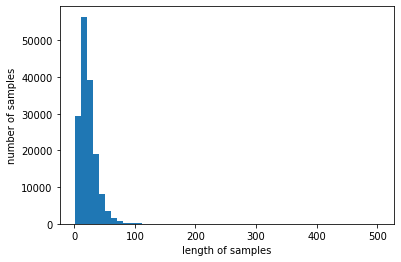

In [ ]:
print('메시지의 최대 길이 :',max(len(l) for l in X_train))
print('메시지의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(80,X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.40854464229535


In [ ]:
max_len = 80
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 모델 정의 및 train

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# best_model 저장해줄 위치. 매번 다르게 해야 됨.
best_model = 'best_model_1117_13.h5'

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(best_model, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# two layer LSTM

embedding_dim2 = 200
hidden_units1 = 128
hidden_units2 = 256
hidden_units3 = 128
hidden_units4 = 128

model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim2))
model2.add(LSTM(hidden_units1,activation='relu',return_sequences = True))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(LSTM(hidden_units2,activation='relu',return_sequences = True))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(LSTM(hidden_units3,activation='relu',return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(hidden_units4,activation='relu',return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1987/1987 [==============================] - ETA: 0s - loss: 4303.6758 - acc: 0.5732
Epoch 00001: val_acc improved from -inf to 0.53615, saving model to best_model_1117_13.h5
1987/1987 [==============================] - 2136s 1s/step - loss: 4303.6758 - acc: 0.5732 - val_loss: 3459.0439 - val_acc: 0.5361
Epoch 2/15
 461/1987 [=====>........................] - ETA: 26:33 - loss: 13.5894 - acc: 0.6582

In [ ]:
# test error
loaded_model = load_model(best_model)
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1243/1243 [==============================] - 30s 23ms/step - loss: 0.5872 - acc: 0.6835

 테스트 정확도: 0.6835


In [ ]:
# train error
loaded_model = load_model(best_model)
print("\n train 정확도: %.4f" % (loaded_model.evaluate(X_train, y_train)[1]))

4967/4967 [==============================] - 113s 22ms/step - loss: 0.5253 - acc: 0.7484

 train 정확도: 0.7484


In [ ]:
model2.predict([[4]])

array([[0.53094757]], dtype=float32)